In [130]:
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd


In [131]:
#First thing first load the data!
data_path = r"C:\Users\jmgwh\Desktop\MASE_6401\Project" #Make sure this is the folder where your data is!
data_files = glob.glob(data_path + "\*.txt")


load_data = pd.read_csv(data_files[0], sep='\t', header=13)
load_data.head() #If you see colums with: Time, Encoder displacement, etc SUCCESS!
print(len(load_data))

2774


In [132]:
#Specimen geometry
width_mm = 1
thickness_mm = 0.5
gauge_length = 4

area_ten = width_mm * thickness_mm

In [173]:
#Stress calculation
load_data['Stress (MPa)'] = -load_data['Load Cell Full Scale (N)']/area_ten
load_data['Stress (MPa)'].head()

0   -0.196770
1   -0.490432
2   -0.394445
3   -0.189289
4    0.026421
Name: Stress (MPa), dtype: float64

In [174]:
dic_files = glob.glob(data_path + "\*.csv")

dic_data = pd.read_csv(dic_files[0], header = 1)
dic_data.head()

,Index [1],exx [1] - Lagrange,eyy [1] - Lagrange
0,0,-5.241660e-17,-4.107700e-17
1,1,-1.301090e-04,-1.888920e-04
2,2,-6.570430e-05,-1.069880e-04
3,3,-2.468980e-04,-4.371670e-04
4,4,-2.326000e-04,-3.655580e-04


In [175]:
load_data['Strain'] = -dic_data['eyy [1] - Lagrange'] / gauge_length
load_data['Strain (%)'] = load_data['Strain']*100



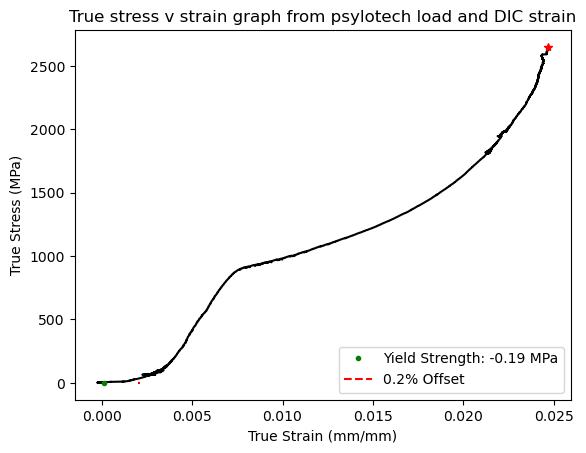

In [176]:
#linear regression function, it will be overused in the following sections
def linear_reg(x, y):	
    x1 = x
    y1 = y
    Ex = np.sum(x1)
    Ey = np.sum(y1)
    x2 = x1**2
    y2 = y1**2
    Ex2 = np.sum(x2)
    Ey2 = np.sum(y2)
    xy = x1*y1
    Exy = np.sum(xy)
    n = len(x1)
    m = ((n*Exy) - (Ex*Ey))/((n*Ex2) - (Ex**2))
    b = (Ey - (m*Ex))/n
    a = np.sqrt((n*Ex2)-(Ex**2))
    a2 = np.sqrt((n*Ey2)-(Ey**2))
    r = ((n*Exy)-(Ex*Ey))/((a)*(a2))

    return m, b, r

slices = np.linspace(0, len(load_data['Strain']-1), 100, dtype = int)

slices_cut = []

for i in range(len(slices)-1):
    start = slices[i]
    stop = slices[i+1]
    x = load_data['Strain'][start:stop]
    y = load_data['Stress (MPa)'][start:stop]
    m, b, r = linear_reg(x,y)
    slices_cut.append(m)
    if m < 0:
        cutoff = start


load_data['Stress 2 (MPa)'] = load_data['Stress (MPa)'][:cutoff]
load_data['Strain 2'] = load_data['Strain'][:cutoff]
load_data['True Stress (MPa)'] = load_data['Stress 2 (MPa)'] * (1+load_data['Strain 2'])
load_data['True Strain'] = np.log(1+load_data['Strain 2'])
                                                                
slc = np.linspace(0, len(load_data['True Strain']-1), 10, dtype=int)

slp = []
inter = []
error = []

for a in range(len(slc)-1):
    start = slc[a]
    stop = slc[a+1]
    x = load_data['True Stress (MPa)'][start:stop]
    y = load_data['True Strain'][start:stop]
    m, b, r = linear_reg(x,y)
    y2 = (((load_data['True Stress (MPa)'])*m)+b)
    slp.append(m)
    inter.append(b)
    error.append(r)

bestm = np.max(slp)
bestint = inter[np.where(slp == bestm)[0][0]]


slopes = np.array(slp)
yoff = (bestm)*(load_data['True Strain']-0.002)
xoff = load_data['True Strain'] + 0.002

truoffy = bestm*load_data['True Strain']

diff = load_data['True Stress (MPa)'] - yoff

ys_idx = np.argwhere(np.diff(np.sign(diff)))[0][0]

offsetx = load_data['True Strain'][ys_idx]
offsety = load_data['True Stress (MPa)'][ys_idx]


UTS = load_data['True Stress (MPa)'].where(load_data['True Stress (MPa)'] == np.max(load_data['True Stress (MPa)']))

UTSx = load_data['True Strain'].where(load_data['True Stress (MPa)'] == UTS)


plt.plot(load_data['True Strain'], load_data['True Stress (MPa)'], 'black')
plt.plot(offsetx, offsety, 'g.', label = f'Yield Strength: {offsety:.2f} MPa')
plt.plot(UTSx, UTS, 'r*')
plt.plot(xoff[:ys_idx], truoffy[:ys_idx], '--', color='red', label = '0.2% Offset')
plt.xlabel('True Strain (mm/mm)')
plt.ylabel('True Stress (MPa)')
plt.title('True stress v strain graph from psylotech load and DIC strain')
plt.legend(loc = 'lower right')

plt.savefig('Stress v strain graph.png')
plt.show()

# Now lets take a look at the microstructures

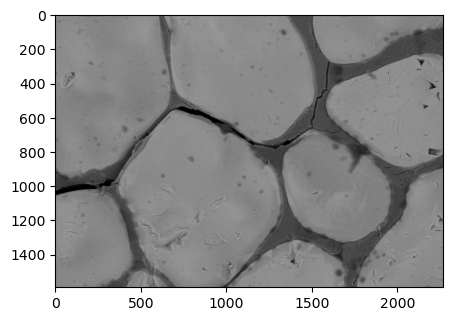

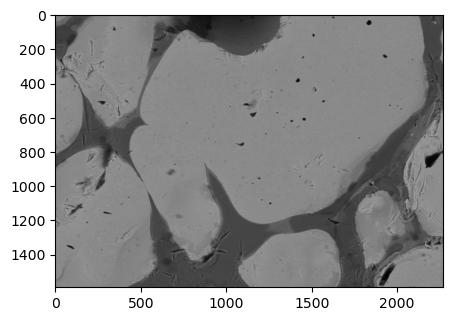

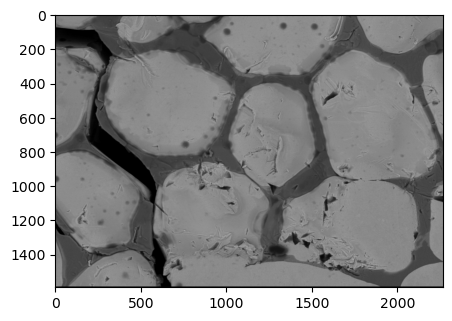

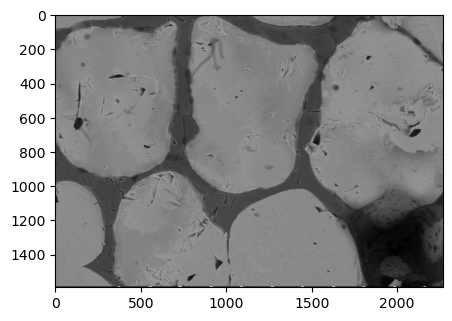

In [43]:
#From the class makes it seamless to show the images
def show_img(image):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(image, cmap = 'gray')
    plt.show()
    plt.close(fig)


#PLace images in folder then copy that folder's path here
image_path = r"C:\Users\jmgwh\Desktop\MASE_6401\Project\Fake_slices"

path = glob.glob(image_path + "\*.tif") #In this case the files are .tif, change it to fit your image files

for image in path:

    image = cv2.imread(image)
    show_img(image)


#Every image is completely different, values will be obtained from Fiji/ImageJ etc
scale_bar = 100 #What is the value of the scale bar (um by default)
distance_in_pixels = 1014
px2um = (scale_bar/distance_in_pixels)

#Sample thickness
tot_t = 40

#Slice thickness
s_t = 10



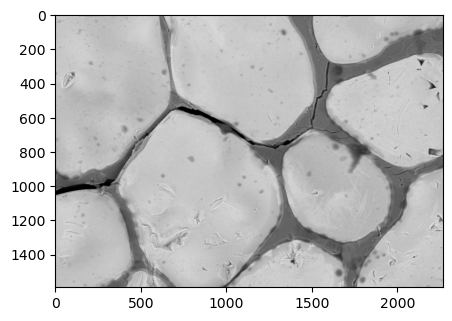

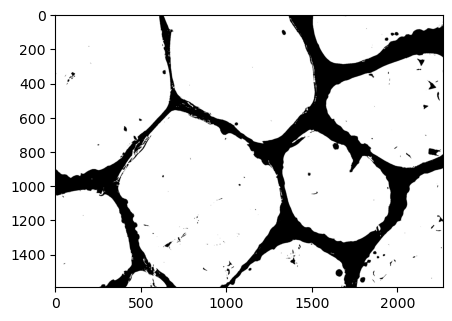

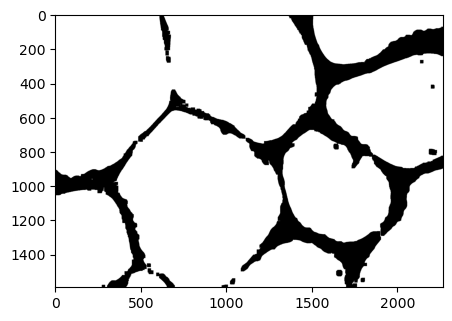

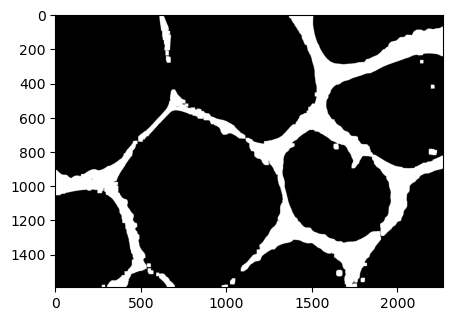

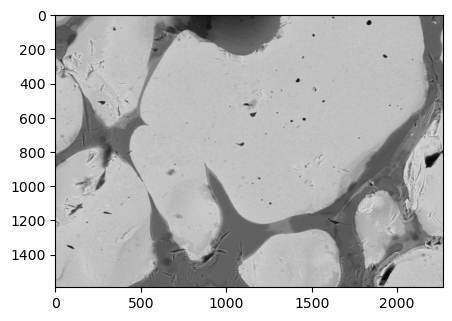

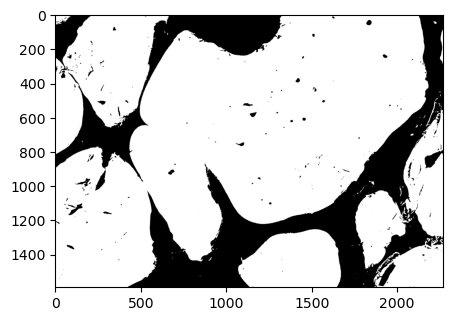

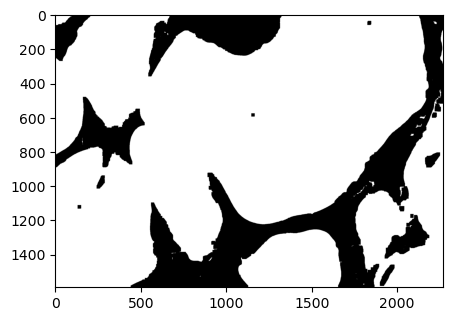

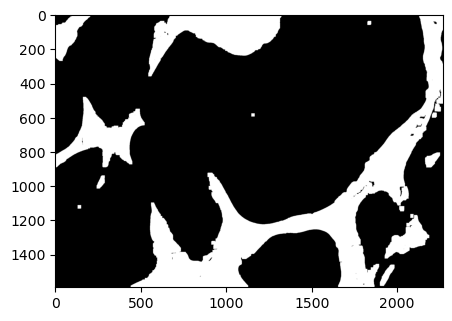

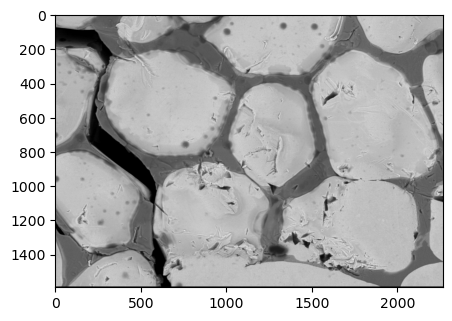

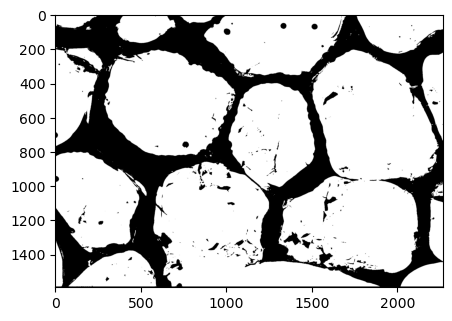

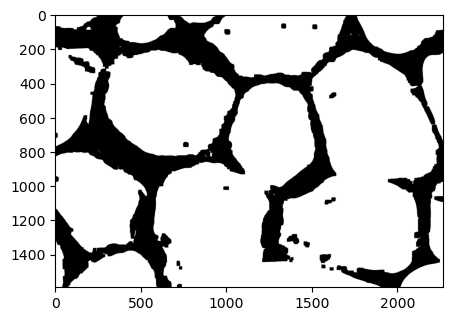

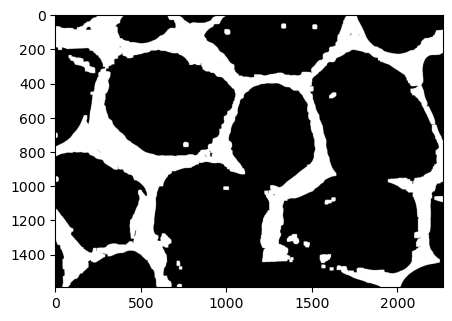

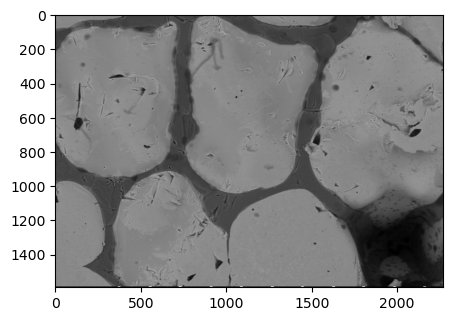

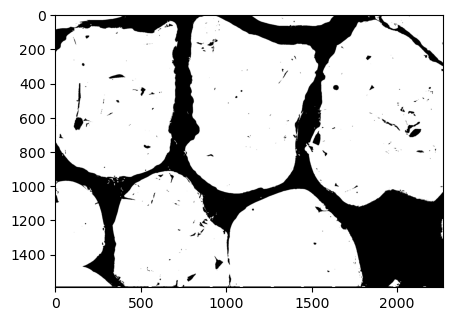

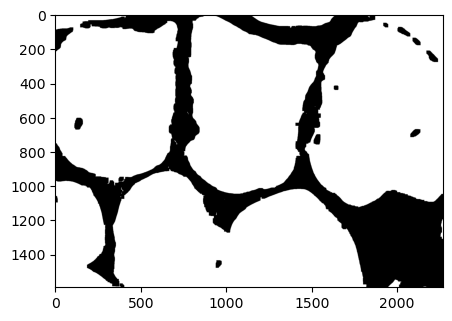

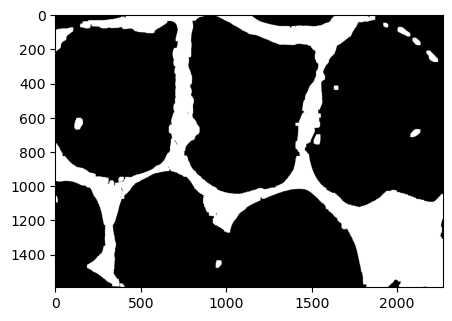

[array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]],
      shape=(1592, 2266), dtype=uint8), array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]],
      shape=(1592, 2267), dtype=uint8), array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]],
      shape=(1592, 2266), dtype=uint8), array([[255, 255, 255, ..., 255, 255, 255],
    

In [57]:
particle_masks = []
phase_masks = []
for image in path:

    image = cv2.imread(image)
    

    #Make image grayscale 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    height, width = gray.shape

    #Making sure these reset for each image to avoid errors
    particle_mask = None
    phase_mask = None


    show_img(gray)
    #From gray scale to binary
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    particle_mask = binary
   
    #Morphological closes to try to clean up images
    
    kernel1 = np.ones((3,3), np.uint8) #Exprimentally obtained kernel size
    kernel2 = np.ones((5,5), np.uint8)
    kernel3 = np.ones((10,10), np.uint8)
    particle_mask = cv2.dilate(particle_mask, kernel1, iterations = 4)
    particle_mask = cv2.morphologyEx(particle_mask, cv2.MORPH_CLOSE, kernel3)
    particle_mask = cv2.erode(particle_mask, kernel2, iterations = 2)
    
    
    phase_mask = cv2.bitwise_not(particle_mask)
    
    
    particle_masks.append(particle_mask)
    phase_masks.append(phase_mask)
    
    show_img(binary)
    show_img(particle_mask)
    show_img(phase_mask)


In [ ]:

#Phase measurement (aka nickel phase)

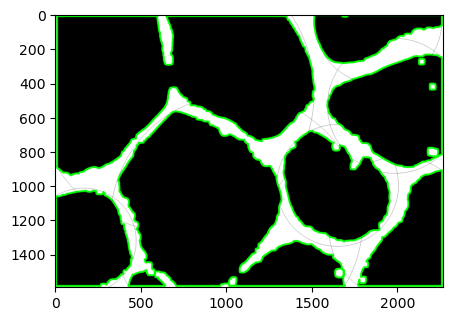

The average grain size is: 58.17284750201685


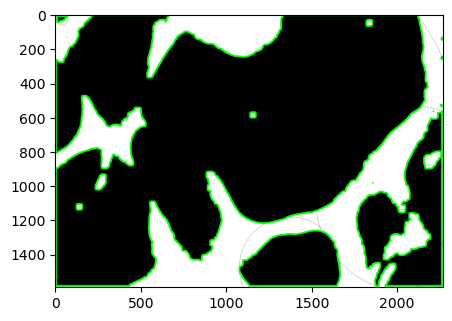

The average grain size is: 44.60748088069912


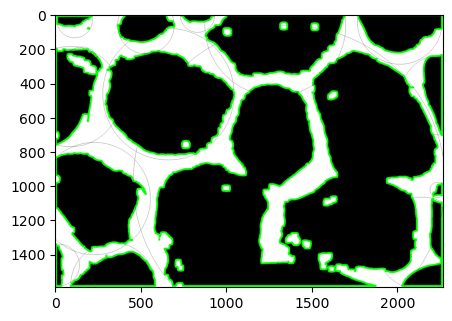

The average grain size is: 36.92444671820237


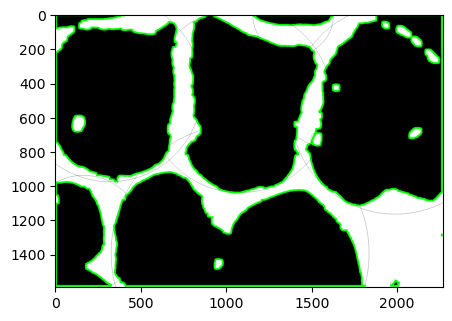

The average grain size is: 37.54783530041546


In [213]:
#Measuring particles
pixel_cnt = []
particle_size = []
equivalent_diameter = []
tungsten_areas = []
for particles in particle_masks:
    #Using a separate contour here to reduce noise even further, with external as far as I recall from google searches only uses the external contours ignoring those ugly holes
    contour_part, p = cv2.findContours(particles, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    colored_pmask = cv2.cvtColor(particles, cv2.COLOR_GRAY2BGR)
    colored_pmask = cv2.bitwise_not(colored_pmask)

    px = cv2.countNonZero(particles)
    pixel_cnt.append(px)
    #Similar to what we did in class but since I have no use for circularity found some very similar but simpler ways to achieve the same results
    for cont in contour_part:
        area = cv2.contourArea(cont)
        particle_size.append(area)
    
        
        
        (cx, cy), r = cv2.minEnclosingCircle(cont)
    
        center = (int(cx), int(cy))
        radius = int(r)
        conts = cv2.circle(colored_pmask, center, radius, (0, 0, 0), 0)
        
        diameter = r*2
        equivalent_diameter.append(diameter)
        cv2.drawContours(colored_pmask, [cont], -1, (0,255,0), 10)
    show_img(conts)
    diam = np.array(equivalent_diameter)
    diameter_um = diam*px2um
    print(f"The average grain size is: {np.mean(diameter_um)}")
    
    tungsten_area = np.sum(particle_size) #This is in pixels!
  
    tungsten_areas.append(tungsten_area)


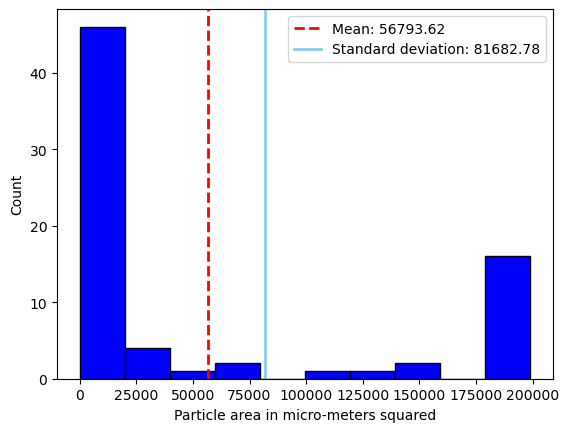

In [214]:

mean_part = np.mean(np.clip(particle_size, 0, particle_size[1]))
std_part = np.std(np.clip(particle_size, 0, particle_size[1]))

plt.hist(np.clip(particle_size, 0, particle_size[1]), color = 'blue', edgecolor = 'black')
plt.axvline(mean_part, color = 'red', linestyle = 'dashed', linewidth =2, label = f'Mean: {mean_part:.2f}')
plt.axvline(std_part, color = 'skyblue', linewidth = 2, label = f'Standard deviation: {std_part:.2f}')
plt.legend()
plt.xlabel('Particle area in micro-meters squared')
plt.ylabel('Count')
plt.savefig('Nodular area histogram.png')
plt.show()


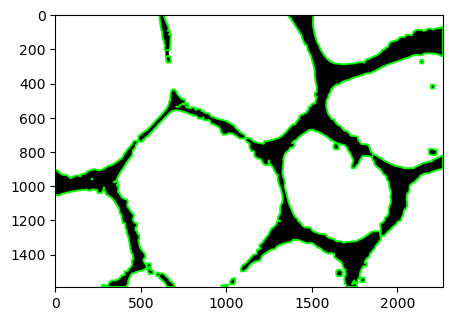

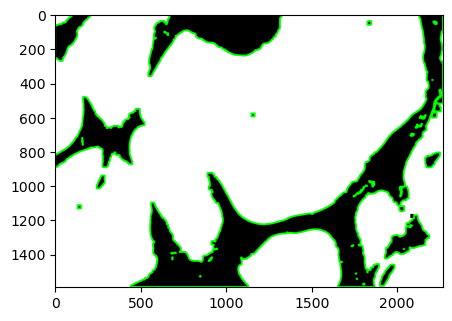

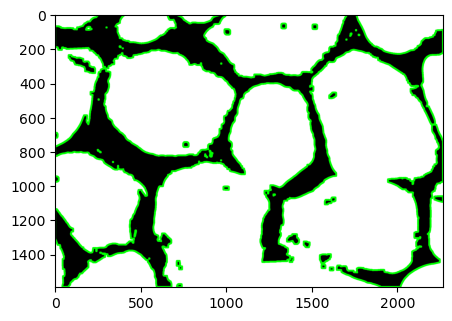

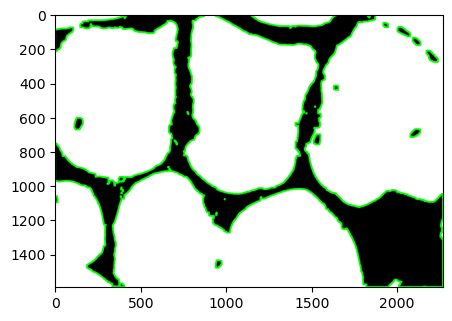

In [211]:
phase_area = []
nickel_areas = []
aspect_ratio = []
for nickels in phase_masks:
    contour_phase, k = cv2.findContours(nickels, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    colored_phmask = cv2.cvtColor(nickels, cv2.COLOR_GRAY2BGR)
    colored_phmask = cv2.bitwise_not(colored_phmask)
    
    for cont in contour_phase:
        area = cv2.contourArea(cont)
        
     
        if len(cont) < 5:
            continue
        ellipses  = cv2.fitEllipse(cont)
        (Cx, Cy), (Maxis, maxis), angle = ellipses
        Maxis_um = Maxis*(100/px2um)
        maxis_um = maxis*(100/px2um)
        aspect = Maxis_um/maxis_um
        aspect_ratio.append(aspect)
        ellipsis_area = np.pi * (Maxis_um/2) * (maxis_um/2)
        phase_area.append(ellipsis_area)
        cv2.drawContours(colored_phmask, [cont], -1, (0,255,0), 10)
    
    show_img(colored_phmask)
    nickel_area = np.sum(phase_area)
    
    nickel_areas.append(nickel_area)

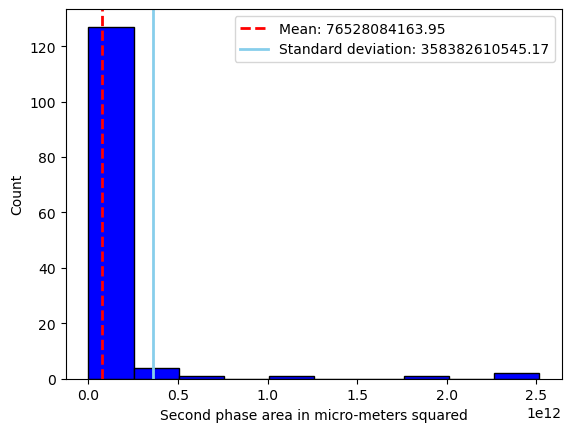

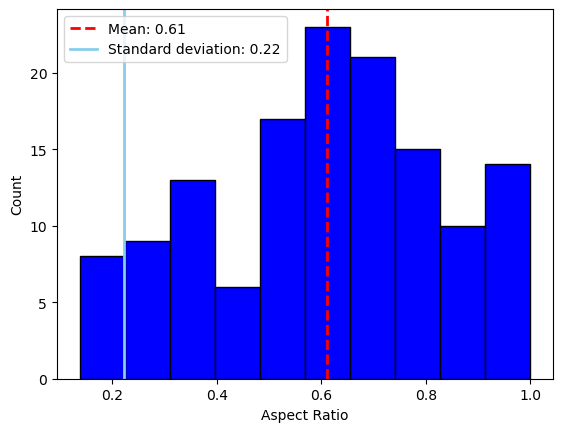

In [218]:
mean_phasearea = np.mean(phase_area)
std_phasearea = np.std(phase_area)

plt.hist(phase_area, color = 'blue', edgecolor = 'black')
plt.axvline(mean_phasearea, color = 'red', linestyle = 'dashed', linewidth =2, label = f'Mean: {mean_phasearea:.2f}')
plt.axvline(std_phasearea, color = 'skyblue', linewidth = 2, label = f'Standard deviation: {std_phasearea:.2f}')
plt.legend()
plt.xlabel('Second phase area in micro-meters squared')
plt.ylabel('Count')
plt.savefig('Second phase.png')
plt.show()




In [222]:
import json
from jsonschema import validate, ValidationError
with open('schema2.json', 'w') as outfile:
    json.dump(schema, outfile, sort_keys=False, indent=4)
schema = {
    '$id' : 'Personal schema',
    '$schema': 'https://json-schema.org/draft/2020-12/schema',
    'title': 'Schema for image analysis of sintered tungsten samples',

    "Mechanical Properties": {
        "Stress": {
            "type": "integer",
            "unit": "MPa",
            "description": "Stress values calculated from load data, units are MPa"
        },
        "Strain": {
            "type": "integer",
            "unit": "Unitless",
            "description": "Strain values obtained from DIC machine, unitless"
        },
    },
    "Image analysis results": {
        "Particle area": {
            "type": "integer",
            "unit": "Micrometer squared",
            "description": "Particle area obtained from image analysis values in um squared, represented in histogram"
        },
        "Intergranular phase area":{
            "type": "integer",
            "unit": "Micrometer squared",
            "description": "Intergranular phase area from image analysis, units in um squared, again represented in a histogram"
        },
    },
}

with open('schema.json', 'w') as outfile:
    json.dump(schema, outfile, sort_keys=False, indent=4)

In [235]:
#json validation

try:
    with open('schema.json', 'r') as infile1:
        json.load(infile1)
except FileNotFoundError:
    print("You sure that exists?")
    

    with open('schema2.json', 'r') as infile2:
        json.load(infile2)
except FileNotFoundError:
    print("You sure that exists?")
    
    
    validate(instance=infile2, schema=infile1)
    print("Looks good!")
except ValidationError:
    print("Validation error:(")